In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import rc, font_manager
ticks_font = font_manager.FontProperties(family='serif', style='normal',
                                         size=24, weight='normal', stretch='normal')
from scipy import optimize
import scipy 
from sympy import *

In [2]:
def f1(x):
    return x[0]**2 + x[1]**2 - 25 , x[0] + x[1] - 7 

In [3]:
optimize.root(f1,[0,1])

    fjac: array([[ 0.88610944,  0.46347606],
       [-0.46347606,  0.88610944]])
     fun: array([-7.10542736e-15,  0.00000000e+00])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([ 2.14263335e-11, -1.12059573e-11])
       r: array([2.15760872, 0.38538953, 0.9269523 ])
  status: 1
 success: True
       x: array([4., 3.])

In [4]:
J2eV = 8.617333262145e-5/1.380649e-23
G = 38*1e9
nu = 0.4
h_b_ratio = np.linspace(1,2,100)
b = 2.86*1e-10

In [5]:
E_elastic = G*b**2/(np.pi*(1-nu))*np.log(h_b_ratio)*J2eV * b

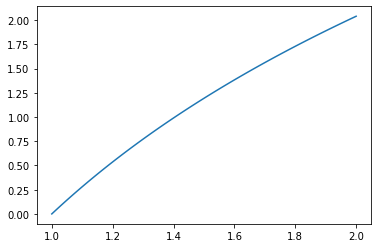

In [6]:
plt.plot(h_b_ratio,E_elastic)

In [7]:
c = np.array([0.32,0.33,0.34,0.0054])
E_wi = np.array([0.054,-0.028,-0.053,0.5])
print(sum(E_wi**2 * c)**(0.5))
print(sum(E_wi[:3]**2 * c[:3])**(0.5))
print(sum(E_wi * c))

0.05913459224514869
0.04633465225940517
-0.007280000000000001


In [8]:
(0.27**2+0.15**2+0.072**2)**(0.5)

0.3171498068736603

In [9]:
from pymatgen.ext.matproj import MPRester

In [10]:
APIKEY = 'HuPNnxxJK15d89zT9R6h'

In [11]:
import numpy as np

In [12]:
class MP_property_getter:
    # grab atomic volume, structure, and elastic constants from materials
    def __init__(self,apikey):
        self.mp = MPRester(apikey)
        
    def get_properties(self,
                       element,
                       structure,
                       criteria=None,
                       properties=None,
                       elasticity='Voigt'):
        # pretty_formula: 
        # criteria: query criteria
        # properties: 
        # elasticity: get shear modulus, default grabs Voigt notation
        #               other notations: Reuss, VRH
        if structure.lower()=='fcc':
            spacegroup_symbol = 'Fm-3m'
        elif structure.lower()=='bcc':
            spacegroup_symbol = 'Im-3m'
        mpcriteria = {"pretty_formula":element,"spacegroup.symbol":spacegroup_symbol}
        if criteria is not None:
            mpcriteria.update(criteria)
        if elasticity == 'Voigt':
            ela_tag = 'Voigt'
        elif elasticity == 'VRH':
            ela_tag = 'Voigt'
        elif elasticity == 'Reuss':
            ela_tag = 'Reuss'
        
        mpproperties = ['pretty_formula',
                        'elasticity.G_{}'.format(ela_tag),'elasticity.poisson_ratio',
                        'elasticity.elastic_anisotropy','spacegroup.symbol','volume',
                        'elasticity.elastic_tensor',
                        'nsites','material_id']
        if properties is not None:
            for prop in properties:
                mpproperties.append(prop)
        self.query_res = self.mp.query(criteria=mpcriteria,
                      properties=mpproperties)
        Cij = self.query_res[0]['elasticity.elastic_tensor']
        zener_ratio = 2*Cij[3][3]/(Cij[0][0]-Cij[0][1])
        self.element_i = {}
        self.element_i[element] = {"structure":structure,
                                   "Vn":np.round(self.query_res[0]['volume']/self.query_res[0]['nsites'],3),
                                   "G":self.query_res[0]['elasticity.G_{}'.format(ela_tag)],
                                   "nu":self.query_res[0]['elasticity.poisson_ratio'],
                                   "anisotropy":np.round(zener_ratio,3),
                                   "spacegroup":self.query_res[0]['spacegroup.symbol'],
                                   "source":self.query_res[0]['material_id']
                                   }

In [13]:
mp_getter = MP_property_getter(APIKEY)

In [14]:
mp_getter.get_properties('Al','fcc',properties=['elasticity.compliance_tensor'])

In [15]:
mp_getter.element_i

{'Al': {'structure': 'fcc',
  'Vn': 16.472,
  'G': 25.0,
  'nu': 0.37,
  'anisotropy': 2.065,
  'spacegroup': 'Fm-3m',
  'source': 'mp-134'}}

In [16]:
mp_getter.query_res[0]['elasticity.elastic_tensor']

[[104.0, 73.0, 73.0, 0.0, 0.0, 0.0],
 [73.0, 104.0, 73.0, 0.0, 0.0, 0.0],
 [73.0, 73.0, 104.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 32.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 32.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 32.0]]

In [17]:
np.array(mp_getter.query_res[0]['elasticity.compliance_tensor'])

array([[23. , -9.5, -9.5, -0. ,  0. ,  0. ],
       [-9.5, 23. , -9.5,  0. , -0. ,  0. ],
       [-9.5, -9.5, 23. , -0. ,  0. , -0. ],
       [-0. ,  0. , -0. , 31.2, -0. ,  0. ],
       [ 0. , -0. ,  0. , -0. , 31.2, -0. ],
       [ 0. ,  0. , -0. ,  0. , -0. , 31.2]])

In [18]:
np.linalg.inv(np.array(mp_getter.query_res[0]['elasticity.elastic_tensor']))

array([[ 0.02283871, -0.00941935, -0.00941935,  0.        ,  0.        ,
         0.        ],
       [-0.00941935,  0.02283871, -0.00941935,  0.        ,  0.        ,
         0.        ],
       [-0.00941935, -0.00941935,  0.02283871,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.03125   ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.03125   ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03125   ]])

In [19]:
C_pq = np.array([[265.0, 158.0, 158.0, 0.0, 0.0, 0.0],
 [158.0, 265.0, 158.0, 0.0, 0.0, 0.0],
 [158.0, 158.0, 265.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 69.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 69.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 69.0]])

In [1803]:
ck_normal = np.array([1,1,1])
sl_normal = np.array([1,1,2])
unit_vector_1 = ck_normal / np.linalg.norm(ck_normal)
unit_vector_2 = sl_normal / np.linalg.norm(sl_normal)
dot_product = np.dot(unit_vector_1, unit_vector_2)
angle = np.arccos(dot_product)
90-np.degrees(angle)

70.52877936550934

In [1472]:
C_ij = mp_getter.query_res[0]['elasticity.elastic_tensor']
C_ij

[[104.0, 73.0, 73.0, 0.0, 0.0, 0.0],
 [73.0, 104.0, 73.0, 0.0, 0.0, 0.0],
 [73.0, 73.0, 104.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 32.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 32.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 32.0]]

In [1918]:



ck_normal = np.array([1,1,1])
ck_front = np.array([-1,1,0])
sp_normal =  np.array([1,1,-1])
sl_dir = np.array([1,1,2])

In [2169]:
class Model_Ductility:
    
    def __init__(self):
        self.C_pq = None # stiffness matrix
        self.ck_normal = None # crack plane normal
        self.ck_front = None # orientation of the crack front
        self.sp_normal = None # slip plane normal
        self.sl_dir = None # slip direction 
    def set_stiffness_matrix(self,C_pq):
        self.C_pq = np.array(C_pq)
    def set_stiffness_matrix_cubic(self,C11_C12_C44):
        C11 = C11_C12_C44[0]
        C12 = C11_C12_C44[1]
        C44 = C11_C12_C44[2]
        self.C_pq = np.array([[C11,C12,C12,0,0,0],[C12,C11,C12,0,0,0],[C12,C12,C11,0,0,0],
                              [0,0,0,C44,0,0],[0,0,0,0,C44,0],[0,0,0,0,0,C44]])
        
    def set_crack_plane(self,crack_plane_normal):
        self.ck_normal = crack_plane_normal / np.linalg.norm(crack_plane_normal)
    def set_crack_front(self,crack_front):
        self.ck_front = crack_front / np.linalg.norm(crack_front)
    def set_slip_plane(self,slip_plane_normal):
        self.sp_normal = slip_plane_normal / np.linalg.norm(slip_plane_normal)
    def set_slip_direction(self,slip_direction):
        self.sl_dir = slip_direction / np.linalg.norm(slip_direction)
    def set_euler_rotation(self,
                       RD = np.array([-1,-1,2]),
                       ND = np.array([1,1,1])):
        # rotation matrix for crack coordinate and sample coordinate

        # set the ND (normal direction) and RD (rolling direction) for crystal frame. 
        ND = ND;RD = RD # default are 111 and -112
        
        # compute rotation matrix
        n = ND/np.linalg.norm(ND)
        b = RD/np.linalg.norm(RD)
        t = np.cross(n,b)/np.linalg.norm(np.cross(n,b))
        Crystal_ij = np.array([b,t,n]).T
        if np.abs(Crystal_ij[2][2]-1)<=1e-6:
            Bunge_Phi = 0    
            Bunge_psi1 = np.arctan(Crystal_ij[0][1]/Crystal_ij[0][0])/2
            Bunge_psi2 = -Bunge_psi1
        else:
            Bunge_Phi = np.arccos(Crystal_ij[2][2])
            Bunge_psi2 = np.arctan2((Crystal_ij[0][2]/np.sin(Bunge_Phi)),(Crystal_ij[1][2]/np.sin(Bunge_Phi)))
            Bunge_psi1 = np.arctan2((Crystal_ij[2][0]/np.sin(Bunge_Phi)),(-Crystal_ij[2][1]/np.sin(Bunge_Phi)))
        
        self.euler_R = Crystal_ij
        self.Bunge_angles = np.array([np.rad2deg(Bunge_Phi),np.rad2deg(Bunge_psi2),np.rad2deg(Bunge_psi1)])
        
    def stiffness_IEEE(self,rotate=False):
        # IEEE standard
        # stiffness tensor Cijkl from Cij 
        i = np.zeros(3)
        C_ijkl = np.einsum('i,j,k,l->ijkl', i,i,i,i)
        C_ijkl_rotate = np.einsum('i,j,k,l->ijkl', i,i,i,i)
        for p in range(6):
            for q in range(6):
                if p <=2:
                    i = p; j = p
                elif p == 3:
                    i = 1; j = 2 # 23 -> 4
                elif p == 4:
                    i = 2; j = 0 # 13 -> 5
                elif p == 5: 
                    i = 0; j = 1 # 12 -> 6
                if q <=2:
                    k = q; l = q
                elif q == 3:
                    k = 1; l = 2
                elif q == 4:
                    k = 2; l = 0
                elif q == 5: 
                    k = 0; l = 1
                #print(p+1,q+1)
                #print(i+1,j+1,k+1,l+1)
                C_ijkl[i][j][k][l] = self.C_pq[p][q]; C_ijkl[j][i][k][l] = self.C_pq[p][q]
                C_ijkl[i][j][l][k] = self.C_pq[p][q]; C_ijkl[j][i][l][k] = self.C_pq[p][q]
        self.C_ijkl = C_ijkl
        
        if rotate: # rotate the stiffness tensor for crack coordinates # require rotation matrix
            for i in range(3):
                for j in range(3):
                    for k in range(3):
                        for l in range(3):
                            for m in range(3):
                                for n in range(3):
                                    for o in range(3):
                                        for p in range(3):
                                            C_ijkl_rotate[i][j][k][l] += self.euler_R[i][m]* self.euler_R[j][n]* self.euler_R[k][o]* self.euler_R[l][p]*C_ijkl[m][n][o][p]
        else:
            C_ijkl_rotate = C_ijkl
        self.C_ijkl_rotate = C_ijkl_rotate
        self.C_ijkl = C_ijkl_rotate
        self.C_ijkl_old = C_ijkl
        return self.C_ijkl,self.C_ijkl_old

    def compliance_tensor(self):
        self.S_pq = np.linalg.inv(self.C_pq)
        #print(S_pq)
    def compliance_tensor_plane_strain(self):
        # 6x6
        self.compliance_tensor()
        ii = np.zeros(6)
        # plane strain compliance
        S_pq_plane_strain = np.einsum('i,k->ik', ii,ii)
        
        for i in range(len(ii)):
            for j in range(len(ii)):
                S_pq_plane_strain[i][j] = self.S_pq[i][j] - self.S_pq[i][2]*self.S_pq[2][j]/self.S_pq[2][2]
        self.S_pq_plane_strain = S_pq_plane_strain
        
    def appropriate_matrix(self,plane_strain=False):
        # return the appropriate matrix Lambda_ij for the self.C_ijkl on the crack coordinate
        # All Equations are in Stroh 1958
        if plane_strain:
            ii = np.zeros(2)
            print('Plane strain condition.')
        else:
            ii = np.zeros(3)
        # --------------------------------------------------------------------------------------
        # first solve p
        # p is a complex vector by defining a matrix of eta
        eta = (np.einsum('i,k->ik', ii,ii)).astype('O') # 3x3 # 2x2 if plane strain = true
        p = symbols('p')
        # Eq.8
        for i in range(len(ii)):
            for k in range(len(ii)):
                Ci1k1 = self.C_ijkl[i][0][k][0]
                Ci1k2 = self.C_ijkl[i][0][k][1]
                Ci2k1 = self.C_ijkl[i][1][k][0]
                Ci2k2 = self.C_ijkl[i][1][k][1]
                eta[i][k] = (Ci2k2*p**2 + (Ci1k2+Ci2k1)*p + Ci1k1)
        eta = Matrix(eta)
        all_roots = (solve(Eq(eta.det(),0)))
        roots = [complex(root) for root in all_roots if np.imag(complex(root))>0] # Eq.8 solved
        # choose the first three roots with positive imaginary parts
        while len(roots)<len(ii):
            roots.append(roots[-1])
        p_roots = np.array(roots)
        print('{} non complex conjugate roots found for p values: {}.'.format(len(p_roots),roots) )
        # --------------------------------------------------------------------------------------
        # Use the p roots to solve Eq.7 to get Ak, the coefficients for the analytic function f(z)
        # Ak is a vector of A1 A2 and A3
        A1,A2,A3=symbols('A1 A2 A3')
        ETA = (np.einsum('a,i,k->aik', ii,ii,ii)).astype('complex') # 3x3 

        # evaluate Ak for all the three sets of p roots, Eq.7
        for a in range(len(p_roots)):
            p_alpha = p_roots[a]
            Ci1k1 = 0; Ci1k2 = 0
            Ci2k1 = 0; Ci2k2 = 0
            for i in range(len(ii)):
                for k in range(len(ii)):
                    Ci1k1 = self.C_ijkl[i][0][k][0]
                    Ci1k2 = self.C_ijkl[i][0][k][1]
                    Ci2k1 = self.C_ijkl[i][1][k][0]
                    Ci2k2 = self.C_ijkl[i][1][k][1]

                    ETA[a][i][k] = (Ci2k2*p_alpha**2 + (Ci1k2+Ci2k1)*p_alpha + Ci1k1)
        #print(ETA)
        Ak_roots_list = []
        Ak_roots_all = []
        if plane_strain:
            for a in range(len(p_roots)):
                eqs = []
                eqs.append(Eq(ETA[a][0][0] * 1 + ETA[a][0][1] * A2,0))
                eqs.append(Eq(ETA[a][1][0] * 1 + ETA[a][1][1] * A2,0))
                # A1 is chosen to be 1 for solving A2 
                Ak = [A2]
                Ak_guess = np.array([1+1j]).astype('complex')
                Ak_roots = nsolve(eqs,Ak,Ak_guess,dict=True)
                Ak_roots[0][A1] = 1
                Ak_roots[0][A3] = 0
                Ak_roots_list.append(Ak_roots)
                Ak_roots_all.append([Ak_roots[0][A1],Ak_roots[0][A2],Ak_roots[0][A3]])
        else:
            for a in range(len(p_roots)):
                eqs_full = [] # full equations to solve Ak, 
                eqs_full.append(Eq(ETA[a][0][0] * A1 + ETA[a][0][1] * A2 + ETA[a][0][2] * A3,0))
                eqs_full.append(Eq(ETA[a][1][0] * A1 + ETA[a][1][1] * A2 + ETA[a][1][2] * A3,0))
                eqs_full.append(Eq(ETA[a][2][0] * A1 + ETA[a][2][1] * A2 + ETA[a][2][2] * A3,0))
                
                eqs = [] # reduced equations to solve Ak, A1 = 1 and solve A2 and A3
                eqs.append(Eq(ETA[a][0][0] * 1 + ETA[a][0][1] * A2 + ETA[a][0][2] * A3,0))
                eqs.append(Eq(ETA[a][1][0] * 1 + ETA[a][1][1] * A2 + ETA[a][1][2] * A3,0))
                eqs.append(Eq(ETA[a][2][0] * 1 + ETA[a][2][1] * A2 + ETA[a][2][2] * A3,0))
                
                if True not in eqs:
                    try:
                        #print(eqs.index(True))
                        Ak = [A1,A2,A3]
                        Ak_guess = np.array([1+1j,1+1j,1+1j]).astype('complex')
                        Ak_roots = nsolve(eqs_full,Ak,Ak_guess,dict=True)
                        Ak_roots_list.append(Ak_roots)
                        Ak_roots_all.append([Ak_roots[0][A1],Ak_roots[0][A2],Ak_roots[0][A3]])
                        print('Ak solved by full equation.')
                    except:
                        #print(eqs.index(True))
                        Ak = [A2,A3]
                        Ak_guess = np.array([1+1j,1+1j]).astype('complex')
                        Ak_roots = nsolve(eqs,Ak,Ak_guess,dict=True)
                        Ak_roots[0][A1] = 1
                        Ak_roots_list.append(Ak_roots)
                        Ak_roots_all.append([Ak_roots[0][A1],Ak_roots[0][A2],Ak_roots[0][A3]])
                        print('Ak solved by reduced equation.')
                else:
                    print('No Ak root found for this p root: {}. Plane strain mode maybe used.'.format(p_roots[a]))
                    a_failed = a
                    continue
            # reorder the solution
            if len(Ak_roots_all) < len(p_roots):
                Ak_roots_all.append([0,0,1])
                p_roots_new = np.append(np.delete(p_roots,a_failed),p_roots[a_failed])
                p_roots = p_roots_new
        Ak_roots_all = np.array(Ak_roots_all).astype('complex')

        # calculate L_ia
        A_ka = Ak_roots_all.T
        # remind A_ka: k = 1,2,3. a = 1,2,3. 
        # --------------------------------------------------------------------------------------
        # then to calculate L_ia, this is Eq.14 or Eq.15
        L_ia1 = (np.einsum('i,k->ik', ii,ii)).astype('complex')
        L_ia2 = (np.einsum('i,k->ik', ii,ii)).astype('complex')
        for i in range(len(ii)):
            for a in range(len(ii)):
                for k in range(len(ii)):
                    L_ia1[i][a] += (self.C_ijkl[i][1][k][0]+p_roots[a]*self.C_ijkl[i][1][k][1])*A_ka[k][a]
                    L_ia2[i][a] += -(self.C_ijkl[i][0][k][1]+p_roots[a]**(-1)*self.C_ijkl[i][0][k][0])*A_ka[k][a] # just for checking the values

        L_ia = L_ia1
        # Now A_ka and L_ia obtained
        # A_ka and L_ia should satisfy Eq.17
        A_ka_conj = np.conjugate(A_ka)
        L_ia_conj = np.conjugate(L_ia)

        # --------------------------------------------------------------------------------------
        # check some values for the obtained A_ka and L_ia. 
        # follow Eq.17
        check_1 = np.round((A_ka_conj[0][0]*L_ia[0][0])*(np.conj(p_roots[0]) - p_roots[0])
                          +(A_ka_conj[1][0]*L_ia[1][0])*(np.conj(p_roots[0]) - p_roots[0])
                          -(A_ka[0][0]*L_ia_conj[0][0])*(-np.conj(p_roots[0]) + p_roots[0])
                          -(A_ka[1][0]*L_ia_conj[1][0])*(-np.conj(p_roots[0]) + p_roots[0]),
                          5)
        check_2 = np.round((A_ka_conj[0][1]*L_ia[0][1])*(np.conj(p_roots[1]) - p_roots[1])
                          +(A_ka_conj[1][1]*L_ia[1][1])*(np.conj(p_roots[1]) - p_roots[1])
                          -(A_ka[0][1]*L_ia_conj[0][1])*(-np.conj(p_roots[1]) + p_roots[1])
                          -(A_ka[1][1]*L_ia_conj[1][1])*(-np.conj(p_roots[1]) + p_roots[1]),
                          5)
        check_3 = np.round((A_ka_conj[0][1]*L_ia[0][0])*(np.conj(p_roots[1]) - p_roots[0])
                          +(A_ka_conj[1][1]*L_ia[1][0])*(np.conj(p_roots[1]) - p_roots[0])
                          -(A_ka[0][0]*L_ia_conj[0][1])*(-np.conj(p_roots[1]) + p_roots[0])
                          -(A_ka[1][0]*L_ia_conj[1][1])*(-np.conj(p_roots[1]) + p_roots[0]),
                          5)
        check_4 = np.round((A_ka_conj[0][0]*L_ia[0][1])*(np.conj(p_roots[0]) - p_roots[1])
                          +(A_ka_conj[1][0]*L_ia[1][1])*(np.conj(p_roots[0]) - p_roots[1])
                          -(A_ka[0][1]*L_ia_conj[0][0])*(-np.conj(p_roots[0]) + p_roots[1])
                          -(A_ka[1][1]*L_ia_conj[1][0])*(-np.conj(p_roots[0]) + p_roots[1]),
                          5)
        # values should be
        print(check_1,check_2,check_3,check_4,'should be zero.')
        # --------------------------------------------------------------------------------------
        
        
        # L_ia verified, then calculate M_ai from L_ia, Eq.37
        M11,M12,M13,M21,M22,M23,M31,M32,M33 = symbols('M11 M12 M13 M21 M22 M23 M31 M32 M33')
        # full matrix to solve is M_ai_sym = Matrix([[M11,M12,M13],[M21,M22,M23],[M31,M32,M33]]) # too many unknowns, 
        M_ai_sym = Matrix([[M11,M12,0],[M21,M22,0],[0,0,M33]]) #so far works for plane strain. # let M13 M23 M32 M31 be 0, determine others # this is for plane strain!!!
        delta_a_b =     M_ai_sym * L_ia
        # kronecker delta 
        eqs1 = [Eq(delta_a_b[0,0],1),Eq(delta_a_b[0,1],0)]
        eqs2 = [Eq(delta_a_b[1,0],0),Eq(delta_a_b[1,1],1)]
        eqs3 = [Eq(delta_a_b[2,2],1)]
        M1_roots = nsolve(eqs1,[M11,M12],[1+1j,1+1j],dict=True)
        M2_roots = nsolve(eqs2,[M21,M22],[1+1j,1+1j],dict=True)
        M3_roots = nsolve(eqs3,[M33],[1+1j],dict=True)

        M11_val = complex(M1_roots[0][M11]);M12_val = complex(M1_roots[0][M12])
        M21_val = complex(M2_roots[0][M21]);M22_val = complex(M2_roots[0][M22])
        M33_val = complex(M3_roots[0][M33])

        #print(M1_roots,M2_roots,M3_roots)
        # Matrix M_ai 
        M_ai1 = np.array([[M11_val,M12_val,0],[M21_val,M22_val,0],[0,0,M33_val]])
        M_ai = M_ai1   
        M_ai_conj = np.conjugate(M_ai)
        # M_ai determined. Then calculate B_ij from Eq.40.
        B_ij = (np.einsum('i,k->ik', ii,ii)).astype('complex')
        for i in range(len(ii)):
            for j in range(len(ii)):
                for a in range(len(ii)):
                    B_ij[i][j] += np.complex(0,1)*(A_ka[i][a]*M_ai[a][j]-A_ka_conj[i][a]*M_ai_conj[a][j])/2
        
        # appropriate matrix
        self.Lambda_ij1 = (np.real(0.5*(B_ij))) # plane strain
        # second method to get appropriate matrix # this should work for both plane strain and more complex conditions
        A = A_ka;B = L_ia; 
        self.Lambda_ij2 = (np.real(np.complex(0,1)*np.dot(A,np.linalg.inv(B))))*0.5
        #print(self.Lambda_ij1,self.Lambda_ij1-self.Lambda_ij2)#, if plane strain, these two should converge
        self.Lambda_ij = self.Lambda_ij2
        self.A = A; self.B = B
        new_A = [];new_B = []
        for vector in B.T:
            new_vector = vector/np.linalg.norm(vector)
            new_B.append(new_vector)
        for vector in A.T:
            new_vector = vector/np.linalg.norm(vector)
            new_A.append(new_vector)
        self.new_A = np.array(new_A).T; self.new_B = np.array(new_B).T
        #return self.Lambda_ij
    
    def angles_phi_theta(self):
        # given crack plane, slip plane and slip direction, calculate angles
        #       self.ck_normal, self.sp_normal, self.sl_dir
        # theta: the angle between crack plane and slip plane
        # phi: on slip plane, the angle between crack tip normal and slip direction
        
        self.theta = np.degrees(np.arccos(np.dot(self.ck_normal, self.sp_normal)))
        # define crack opening direction 
        
        ck_open_dir = np.cross(self.ck_normal,self.ck_front) # crack opening direction
        
        vec_x = (self.ck_normal * np.sin(np.deg2rad(self.theta)) + ck_open_dir * np.cos(np.deg2rad(self.theta)))
        vec_x_norm = vec_x / np.linalg.norm(vec_x)
        
        self.psi = np.degrees(np.arccos(np.round(np.dot(vec_x_norm, self.sl_dir),5)))
        #print(self.theta,self.psi)
    
    def rotation_matrix(self):
        # rotation matrix for slip plane and crack plane
        self.Rij = np.array([
            [np.cos(np.deg2rad(self.theta)),np.sin(np.deg2rad(self.theta)),0],
            [-np.sin(np.deg2rad(self.theta)),np.cos(np.deg2rad(self.theta)),0],
            [0,0,1]])
    def slip_phi(self):
        self.s_i_phi = np.array([np.cos(np.deg2rad(self.psi)), 0, np.sin(np.deg2rad(self.psi))])

        
    def calc_o(self,theta_usr=None,psi_usr=None):
        
        # anisotropic elasticity property o(phi,theta)
        self.angles_phi_theta() # get self.theta and self.psi from vectors
        if theta_usr:
            self.theta = theta_usr
        if psi_usr:
            self.psi = psi_usr
        self.rotation_matrix() #self.Rij
        #print(self.Rij)
        self.slip_phi() # self.s_i_phi 
        #print(self.Lambda_ij)
        Lambda_theta = np.dot(np.dot(self.Rij.T,(self.Lambda_ij)),self.Rij)
        self.Lambda_theta = Lambda_theta
        
        #print(Lambda_theta)
        self.anisotropic_o = np.dot(np.dot(self.s_i_phi,Lambda_theta),self.s_i_phi.T)
    

In [2170]:
C11_22_44_Al_1 = np.array([113.4,61.5,31.6])
C11_22_44_Al_2 = np.array([118.0,62.2,36.7])
C11_22_44_Au = np.array([183.2,158.7,45.3])
C11_22_44_Ag = np.array([129.1,91.7,56.7])
C11_22_44_Cu = np.array([169.9,122.6,76.2])
C11_22_44_Pd = np.array([221.1,183.0,72.6])
C11_22_44_Ni = np.array([247.9,147.8,124.8])
C11_22_44_Cr_10 = np.array([301.3,171.5,156.7])
C11_22_44_Cr_20 = np.array([276.6,165.6,148.7])
C11_22_44_Cr_33 = np.array([246.6,158.1,138.5])
C11_22_44_Cr_40 = np.array([232.6,154.7,133.7])
C11_22_44_Cr_50 = np.array([213.1,150.8,127.6])
C11_22_44_Cr_60 = np.array([205.5,150.3,124.6])
C11_22_44_Cr_70 = np.array([204.5,152.8,124.6])
C11_22_44_Cr_80 = np.array([211.2,159.0,127.9])
C11_22_44_Cr_90 = np.array([225.6,168.9,134.9])
C11_22_44_Cr_100 = np.array([247.3,182.5,145.5])

In [2176]:
model = Model_Ductility()
model.set_stiffness_matrix_cubic(C11_22_44_Cr_20)
model.set_euler_rotation(ND=np.array([1,1,1]),RD=np.array([-1,-1,2]))
model.stiffness_IEEE(rotate=True)
model.compliance_tensor()
model.compliance_tensor_plane_strain()
model.appropriate_matrix()

model.set_crack_plane(ck_normal)
model.set_crack_front(ck_front)
model.set_slip_direction(sl_dir)
model.set_slip_plane(sp_normal)

model.angles_phi_theta()

3 non complex conjugate roots found for p values: [(-0.14940473476908891+2.033832961734017j), (-0.03592497743690901+0.48904342538850554j), (0.3890430243704313+0.9212195857604787j)].
Ak solved by full equation.
Ak solved by full equation.
Ak solved by full equation.
(-0+0j) -0j (-0-0j) -0j should be zero.


In [2177]:
model.calc_o(theta_usr=70,psi_usr=60)
print(1/model.anisotropic_o)
model.calc_o(theta_usr=70.5,psi_usr=0)
print(1/model.anisotropic_o)
print(np.linalg.eig(np.linalg.inv(model.Lambda_ij))[0])
np.linalg.inv(model.Lambda_ij)

215.1284624398002
276.05160260515385
[312.67257171 269.96275816 191.23595515]


array([[289.36987139,  19.40711323, -15.13095035],
       [ 19.40711323, 289.36987139, -15.13095035],
       [-15.13095035, -15.13095035, 195.13154224]])

In [2178]:
1/model.Lambda_theta[1][1],1/model.Lambda_ij[1][1]

(298.9458661714668, 287.042952117339)

In [2180]:
np.linalg.eig(np.linalg.inv(model.Lambda_ij))

(array([312.67257171, 269.96275816, 191.23595515]),
 array([[ 6.95672631e-01,  7.07106781e-01,  1.26647503e-01],
        [ 6.95672631e-01, -7.07106781e-01,  1.26647503e-01],
        [-1.79106616e-01, -8.72879699e-15,  9.83829670e-01]]))

In [2181]:
Matrix(np.round(np.dot(model.new_B.T,model.new_A)+np.dot(model.new_A.T,model.new_B),5))

Matrix([
[ 0.65538 + 1.37308*I,                    0, -0.01974 + 0.00458*I],
[                   0, -1.24759 + 0.87086*I,  0.01501 - 0.01362*I],
[-0.01974 + 0.00458*I,  0.01501 - 0.01362*I,  1.73305 + 0.62832*I]])

In [2182]:
Matrix(np.round(np.dot(model.new_B.T,np.conjugate(model.new_A))+np.dot(model.new_A.T,np.conjugate(model.new_B)),5))

Matrix([
[                   0,                   0, -0.13967 - 0.00955*I],
[                   0,                   0,  0.02204 + 0.13825*I],
[-0.13967 + 0.00955*I, 0.02204 - 0.13825*I,                    0]])

In [2183]:
Matrix(model.B.T/np.array([np.linalg.norm(model.B.T[0]),np.linalg.norm(model.B.T[1]),np.linalg.norm(model.B.T[2])]))

Matrix([
[ -0.177286801887671 - 0.875251283683486*I,   0.142825775716937 - 0.0400175037719633*I, -0.0802502554992858 + 0.0460461279054118*I],
[  -1.11467481742762 - 0.654921368276868*I,    0.394762235453585 - 0.801035702807831*I,    0.194390999661075 + 0.191900004049175*I],
[0.224878249627987 - 0.00582319755894649*I, -0.0278164204590697 + 0.0709367503928851*I,   -0.550454681043298 - 0.785084699469793*I]])

In [2184]:
o_70_60 = []
o_70_0 = []
C_data = pd.read_csv('./data_anisotropic_o.csv',sep=',')
C_data.columns

Index(['name', 'C11', 'C12', 'C44', 'o_70_0', 'o_70_60'], dtype='object')

In [2185]:
for i in range(len(C_data)):
    print('Name: {}.'.format(C_data['name'][i]))
    C11_12_44 = np.array([C_data['C11'][i],C_data['C12'][i],C_data['C44'][i]])
    model = Model_Ductility()
    model.set_stiffness_matrix_cubic(C11_12_44)
    model.set_euler_rotation(ND=np.array([1,1,1]),RD=np.array([-1,-1,2]))
    model.stiffness_IEEE(rotate=True)
    model.compliance_tensor()
    model.compliance_tensor_plane_strain()
    model.appropriate_matrix()
    model.set_crack_plane(ck_normal)
    model.set_crack_front(ck_front)
    model.set_slip_direction(sl_dir)
    model.set_slip_plane(sp_normal)
    model.angles_phi_theta()
    # o_70_60
    model.calc_o(theta_usr=70.5,psi_usr=60)
    o_70_60.append(1/model.anisotropic_o)
    # o_70_0
    model.calc_o(theta_usr=70.5,psi_usr=0)
    o_70_0.append(1/model.anisotropic_o)
    print(np.linalg.eig(np.linalg.inv(model.Lambda_ij))[0])
    np.linalg.inv(model.Lambda_ij)
    

Name: Al_1.
3 non complex conjugate roots found for p values: [(-0.013744458534623395+1.4033610977009554j), (-0.0069782594512112625+0.7125066308595938j), (0.08369223004381568+0.9964916510590006j)].
Ak solved by full equation.
Ak solved by full equation.
Ak solved by full equation.
0j -0j -0j (-0-0j) should be zero.
[89.07604138 87.11713927 57.89859322]
Name: Al_2.
3 non complex conjugate roots found for p values: [(-0.022197844947099477+1.4843302979770798j), (-0.010072855217685408+0.6735538617545225j), (0.1160052918165562+0.9932485954032634j)].
Ak solved by full equation.
Ak solved by full equation.
Ak solved by full equation.
(-0+0j) -0j -0j (-0-0j) should be zero.
[98.89792485 95.66216478 64.96478966]
Name: Au.
3 non complex conjugate roots found for p values: [(-0.09288253758393164+2.4767405207196247j), (-0.015120379545630723+0.40318942272096575j), (0.47511256848879047+0.87992502366053j)].
Ak solved by full equation.
Ak solved by full equation.
Ak solved by full equation.
0j -0j 0j 

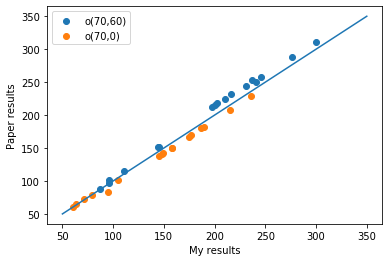

In [2186]:
plt.scatter(o_70_0,C_data['o_70_0'],label='o(70,60)')
plt.scatter(o_70_60,C_data['o_70_60'],label='o(70,0)')
plt.plot([50,350],[50,350])
plt.xlabel('My results')
plt.ylabel('Paper results')
plt.legend()

In [1790]:
ND = np.array([1,1,1])
#ND = np.array([0,0,1])
RD = np.array([-1,-1,2])
TD = np.array([-1,1,0])

n = ND/np.linalg.norm(ND)
b = RD/np.linalg.norm(RD)
t = np.cross(n,b)/np.linalg.norm(np.cross(n,b))

Crystal_ij = np.array([b,t,n]).T

In [1791]:
t,Crystal_ij

(array([ 0.70710678, -0.70710678,  0.        ]),
 array([[-0.40824829,  0.70710678,  0.57735027],
        [-0.40824829, -0.70710678,  0.57735027],
        [ 0.81649658,  0.        ,  0.57735027]]))

In [1770]:
if np.abs(Crystal_ij[2][2]-1)<=1e-6:
    Bunge_Phi = 0    
    Bunge_psi1 = np.arctan(Crystal_ij[0][1]/Crystal_ij[0][0])/2
    Bunge_psi2 = -Bunge_psi1
else:
    Bunge_Phi = np.arccos(Crystal_ij[2][2])
    Bunge_psi2 = np.arctan((Crystal_ij[0][2]/np.sin(Bunge_Phi))/(Crystal_ij[1][2]/np.sin(Bunge_Phi)))
    Bunge_psi1 = np.arctan((Crystal_ij[2][0]/np.sin(Bunge_Phi))/(-Crystal_ij[2][1]/np.sin(Bunge_Phi)))
np.rad2deg(Bunge_Phi),np.rad2deg(Bunge_psi2),np.rad2deg(Bunge_psi1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


(54.735610317245346, 45.0, -90.0)

In [1771]:
np.rad2deg(np.arccos(np.dot(t,sp_normal/np.linalg.norm(sp_normal))))

90.0

In [1947]:
Matrix([[1.00000000000000, 1.00000000000000, 1.00000000000000], [-0.0493192518108334 + 0.153214017773719*I, -1.90370929842864 + 5.91401814861617*I, -0.681957966731014 - 0.731391366924782*I], [0.0583250660636737 - 0.127311643304113*I, -0.863957339627555 + 0.102571140063532*I, 4.39869374134611 - 10.1155391163207*I]])

Matrix([
[                                      1.0,                                      1.0,                                      1.0],
[-0.0493192518108334 + 0.153214017773719*I,   -1.90370929842864 + 5.91401814861617*I, -0.681957966731014 - 0.731391366924782*I],
[ 0.0583250660636737 - 0.127311643304113*I, -0.863957339627555 + 0.102571140063532*I,    4.39869374134611 - 10.1155391163207*I]])